# README

## Overview
This cell performs a comparative analysis of GNN (Graph Neural Network) models and baseline QSAR (Quantitative Structure-Activity Relationship) models for both classification and regression tasks. It includes data loading, metric extraction, and visualization of results using bar charts and radar plots.

## Features
1. **Classification Accuracy Comparison**:
    - Loads classification accuracy metrics for GNN models and the baseline QSAR model.
    - Automatically selects the best baseline model based on accuracy.
    - Displays the results in a tabular format.
    - Generates bar charts and radar plots to visualize the classification accuracy comparison.

2. **Regression R² Comparison**:
    - Loads regression R² metrics for GNN models and the baseline QSAR model.
    - Automatically selects the best baseline model based on R² score.
    - Displays the results in a tabular format.
    - Generates bar charts and radar plots to visualize the regression R² comparison.

3. **Visualization**:
    - Saves the generated plots as image files for further use.
    - Includes both GNN and baseline QSAR metrics for comparison.

## Dependencies
- Python 3.x
- Libraries:
  - `pandas`: For data manipulation and analysis.
  - `numpy`: For numerical operations.
  - `matplotlib`: For creating visualizations.

## How to Use
1. Ensure the required CSV files are available at the specified paths:
    - Classification: `../6_baseline_comparison/QSAR_classification_performance_summary.csv`
    - Regression: `../6_baseline_comparison/QSAR_regression_performance_summary.csv`

2. Adjust the file paths and parameters (e.g., `models`, `task_dirs`) as needed.

3. Run the cell to:
    - Load and process the data.
    - Compare GNN and baseline QSAR models.
    - Visualize the results.

4. The generated plots will be saved as PNG files in the current working directory.

## Outputs
- **Bar Charts**:
  - `GNN_classification_accuracy_vs_baseline_bar.png`: Classification accuracy comparison.
  - `GNN_regression_r2_vs_baseline_bar_colored.png`: Regression R² comparison.

- **Radar Plots**:
  - `GNN_classification_accuracy_vs_baseline_radar.png`: Classification accuracy comparison.
  - `GNN_regression_r2_vs_baseline_radar.png`: Regression R² comparison.



## Compare GNNs vs. QSAR Baseline (interactive prompts for missing metrics)


,accuracy
GIN,0.698113
GCN,0.698113
MPNN,0.735849
GraphSAGE,0.735849
GAT,0.735849
Baseline QSAR,0.828283


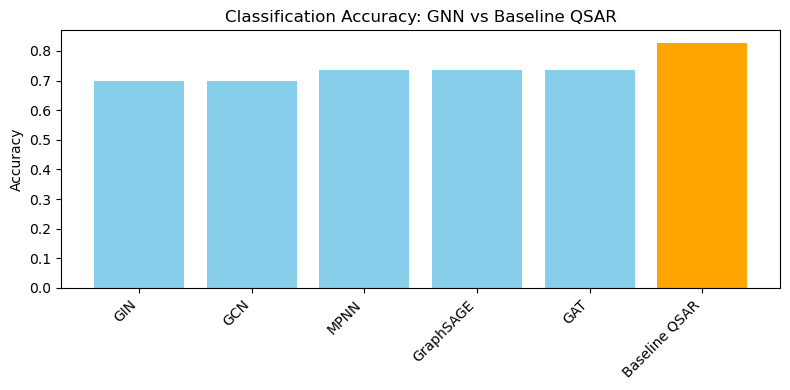

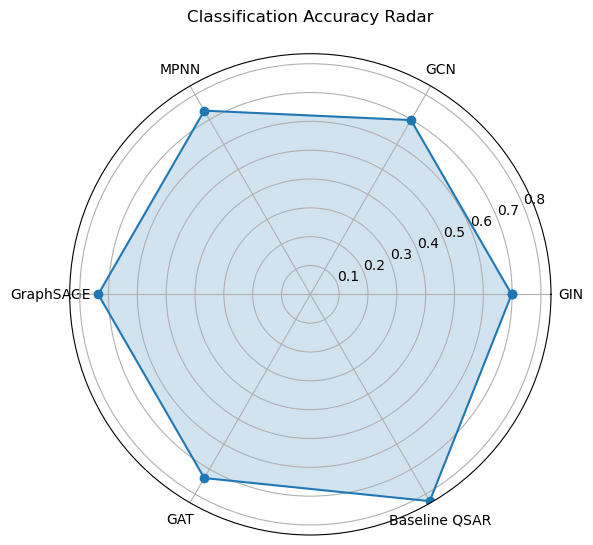

,r2
GIN,0.559820
GCN,0.382937
MPNN,0.528056
GraphSAGE,0.413552
GAT,0.334502
Baseline QSAR,0.655247


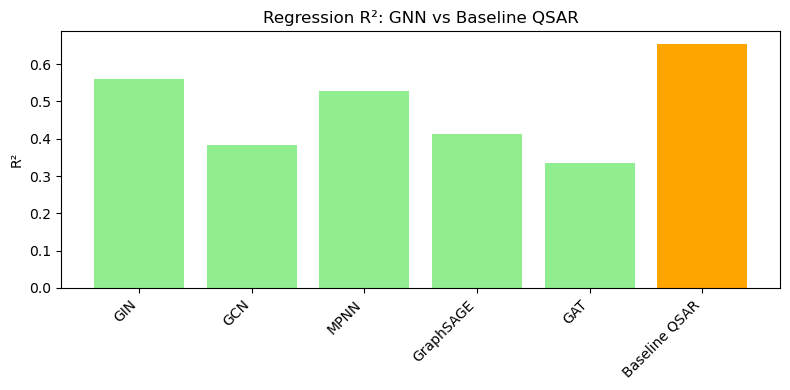

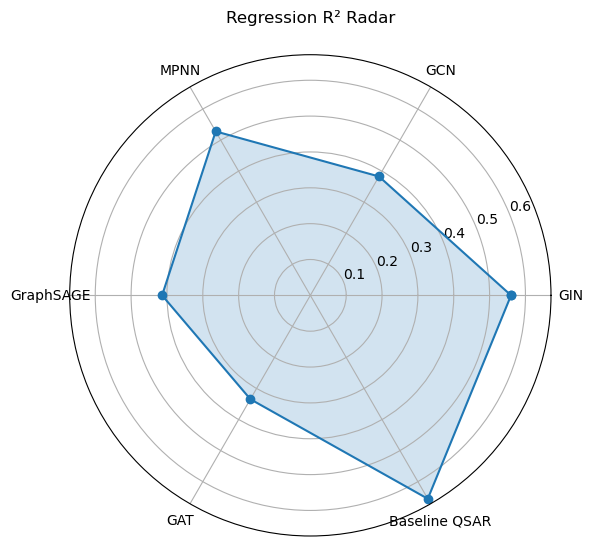

In [36]:
# %% [markdown]
# ## Compare GNNs vs. QSAR Baseline (no prompts, assume metrics files present)

# %%
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
models = ["GIN", "GCN", "MPNN", "GraphSAGE", "GAT"]
base_folder = "../5_model_training"
task_dirs = {
    "classification": "classification_10fold",
    "regression":     "regression_10fold"
}
baseline_class_csv = "../6_baseline_comparison/QSAR_classification_performance_summary.csv"
baseline_reg_csv   = "../6_baseline_comparison/QSAR_regression_performance_summary.csv"

# Metric keys
class_metric = "accuracy"
reg_metric   = "r2"

# --- 1) Classification Accuracy ---
# load baseline
bdf = pd.read_csv(baseline_class_csv)
baseline_acc = bdf[class_metric].max()
baseline_class_csv = "../6_baseline_comparison/QSAR_classification_performance_summary.csv"
baseline_reg_csv = "../6_baseline_comparison/QSAR_regression_performance_summary.csv"
# load each GNN
class_results = {}
for m in models:
    path = os.path.join(base_folder, m, f"{m}_results", task_dirs["classification"], "final_metrics.csv")
    df = pd.read_csv(path)
    class_results[m] = df.loc[0, class_metric]

# add baseline
class_results["Baseline QSAR"] = baseline_acc

# build DataFrame & plot
class_df = pd.Series(class_results, name=class_metric).to_frame()
display(class_df)

plt.figure(figsize=(8,4))
colors = ["skyblue" if m!="Baseline QSAR" else "orange" for m in class_df.index]
plt.bar(class_df.index, class_df[class_metric], color=colors)
plt.title("Classification Accuracy: GNN vs Baseline QSAR")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# radar
labels = class_df.index.tolist()
values = class_df[class_metric].tolist()
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles_loop = np.concatenate([angles, angles[:1]])
values_loop = values + values[:1]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles_loop, values_loop, marker="o")
ax.fill(angles_loop, values_loop, alpha=0.2)
ax.set_xticks(angles)
ax.set_xticklabels(labels)
ax.set_title("Classification Accuracy Radar", y=1.05)
plt.tight_layout()
plt.show()


# --- 2) Regression R² ---
rdf = pd.read_csv(baseline_reg_csv)
baseline_r2 = rdf[reg_metric].max()

reg_results = {}
for m in models:
    path = os.path.join(base_folder, m, f"{m}_results", task_dirs["regression"], "final_metrics.csv")
    df = pd.read_csv(path)
    reg_results[m] = df.loc[0, reg_metric]

reg_results["Baseline QSAR"] = baseline_r2

reg_df = pd.Series(reg_results, name=reg_metric).to_frame()
display(reg_df)

plt.figure(figsize=(8,4))
colors = ["lightgreen" if m!="Baseline QSAR" else "orange" for m in reg_df.index]
plt.bar(reg_df.index, reg_df[reg_metric], color=colors)
plt.title("Regression R²: GNN vs Baseline QSAR")
plt.ylabel("R²")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# radar
labels = reg_df.index.tolist()
values = reg_df[reg_metric].tolist()
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles_loop = np.concatenate([angles, angles[:1]])
values_loop = values + values[:1]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles_loop, values_loop, marker="o")
ax.fill(angles_loop, values_loop, alpha=0.2)
ax.set_xticks(angles)
ax.set_xticklabels(labels)
ax.set_title("Regression R² Radar", y=1.05)
plt.tight_layout()
plt.show()
